# 0.0 Import Libraries

In [1]:
pip install spectral mat73  einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1.0 Upload Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

 2013_DFTC						 best_model_p13_weights.pth
 2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat	 best_model_p15_weights.pth
 2013_IEEE_GRSS_DF_Contest_LiDAR.mat			 best_model_p3_weights.pth
 ablationp5_spatialonly_UH2013_model_state_dict.pth	 best_model_p7_weights.pth
 ablationp7_removeZpath_Uh2013_model_state_dict.pth	 best_model_p9_weights.pth
 ablationp7_removeZpath_UH2013_model_state_dict.pth	 best_model.pth
 ablationp7_spatialonly_Uh2013_model_state_dict.pth	 best_model_weights.pth
 ablationp7_spatialonly_UH2013_model_state_dict.pth	 best_model_wts.pth
 ablationp7_Uh2013_model_state_dict.pth			 BS_RLFCC_UH2013.ipynb
 ablationp7_UH2013_model_state_dict.pth			 cae_model_state_batchscore.pth
 ablation_Uh2013_model_state_dict.pth			 cae_model_state.pth
 ablation_UH2013_model_state_dict.pth			'Contrastive Best model'
 Autoencodermodel.pth					 cross_modal_autoencoder_best.pth
 Autoencodermodel_uh2013_20Ksample.pth			 cross_modal_autoencoder.pth
 Autoencodermodel_uh2013_adam_20Ksample.pth	

In [5]:
# Define the path
path='/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

In [6]:
# 2.1 Loads Data
# Load hyperpsectral data
hsi_2013_data=sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('hsi_2013_data shape:', hsi_2013_data.shape)

# Loader Lidar  data
import mat73
lidar_2013_data = sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']

print('Lidar_2013_data shape:', lidar_2013_data.shape)

#Load ground truth labels
gt_2013_data=sio.loadmat(path+'GRSS2013.mat')['name']
print('gt_2013_data.shape:', gt_2013_data.shape)

hsi_2013_data shape: (349, 1905, 144)
Lidar_2013_data shape: (349, 1905, 1)
gt_2013_data.shape: (349, 1905)


# 2.0 Data Preprocessing & Dataloader Preparation

In [7]:
# 2.1 Define the class information
class_info = [(1, "Healthy grass", 'training_sample', 198, 'test_sample', 1053,  'total', 1251),
    (2, "Stressed grass",'training_sample', 190, 'test_sample', 1064,  'total', 1254),
    (3, "Synthetic grass", 'training_sample', 192, 'test_sample', 505,  'total', 697),
    (4, "Trees", 'training_sample', 188, 'test_sample', 1058,  'total', 1244),
    (5, "Soil",'training_sample', 186, 'test_sample', 1056,  'total', 1242),
    (6, "Water", 'training_sample', 182, 'test_sample', 141,  'total', 325),
    (7, "Residential", 'training_sample', 196, 'test_sample', 1072,  'total', 1268),
    (8, "Commercial", 'training_sample', 191, 'test_sample', 1053,  'total', 1244),
    (9, "Road", 'training_sample', 193, 'test_sample', 1059,  'total', 1252),
    (10, "Highway", 'training_sample', 191, 'test_sample', 1036,  'total', 1227),
    (11, "Railway", 'training_sample', 181, 'test_sample', 1054,  'total', 1235),
    (12, "Parking lot 1", 'training_sample', 192, 'test_sample', 1041,  'total', 1233),
    (13, "Parking lot 2", 'training_sample', 184, 'test_sample',285,  'total', 469),
    (14, "Tennis court",'training_sample', 181, 'test_sample', 247,  'total', 428),
    (15, "Running track", 'training_sample', 187, 'test_sample', 473,  'total', 660)]

# Create a dictionary to store class number, class name, and class samples
class_dict = {class_number: {"class_name": class_name,
                             'training_sample': training_sample,
                             'test_sample': test_sample,
                             "total_samples": total}
              for class_number, class_name, _, training_sample, _, test_sample, _, total in class_info}

print(class_dict)

{1: {'class_name': 'Healthy grass', 'training_sample': 198, 'test_sample': 1053, 'total_samples': 1251}, 2: {'class_name': 'Stressed grass', 'training_sample': 190, 'test_sample': 1064, 'total_samples': 1254}, 3: {'class_name': 'Synthetic grass', 'training_sample': 192, 'test_sample': 505, 'total_samples': 697}, 4: {'class_name': 'Trees', 'training_sample': 188, 'test_sample': 1058, 'total_samples': 1244}, 5: {'class_name': 'Soil', 'training_sample': 186, 'test_sample': 1056, 'total_samples': 1242}, 6: {'class_name': 'Water', 'training_sample': 182, 'test_sample': 141, 'total_samples': 325}, 7: {'class_name': 'Residential', 'training_sample': 196, 'test_sample': 1072, 'total_samples': 1268}, 8: {'class_name': 'Commercial', 'training_sample': 191, 'test_sample': 1053, 'total_samples': 1244}, 9: {'class_name': 'Road', 'training_sample': 193, 'test_sample': 1059, 'total_samples': 1252}, 10: {'class_name': 'Highway', 'training_sample': 191, 'test_sample': 1036, 'total_samples': 1227}, 11: 

### 2.1  Samples Extraction

In [8]:
# 2.2 Samples Extraction

# # Create a mask with all class labels
# mask = np.copy(gt_2013_data)

# # Set the background class to 0
# mask[mask == 0] = 0

# Define patch size and stride
patch_size = 9
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["total_samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["total_samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels) # GT
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 9, 9, 144)
lidar_samples shape: (15029, 9, 9, 1)
labels shape: (15029,)


### 2.2 Training samples extraction

In [9]:
#Avoid overlap of train and test
# Extracting training samples
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
used_indices = []  # To keep track of indices already taken for training samples

for label, class_data in class_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Take the required number of training samples
    train_indices = class_indices[:class_data["training_sample"]]
    used_indices.extend(train_indices)  # Add these to the used_indices list

    # Append training samples
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

# Extracting test samples
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

for label, class_data in class_dict.items():
    class_indices = np.where(labels == label)[0]

    # Exclude indices which were used for training
    test_indices = np.setdiff1d(class_indices, used_indices)

    # Append test samples
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


hsi_training_samples shape: (2832, 9, 9, 144)
lidar_training_samples shape: (2832, 9, 9, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 9, 9, 144)
lidar_test_samples shape: (12197, 9, 9, 1)
test_labels shape: (12197,)


In [10]:
hsi_train=hsi_training_samples
lidar_train=lidar_training_samples
y_train=training_labels
print('hsi_train_samples shape:', hsi_train.shape)
print('lidar_train_samples shape:', lidar_train.shape)
print('train_labels shape:', y_train.shape)
hsi_test=hsi_test_samples
lidar_test=lidar_test_samples
y_test=test_labels
print('hsi_test_samples shape:', hsi_test.shape)
print('lidar_test_samples shape:', lidar_test.shape)
print('y_test shape:', y_test.shape)

hsi_train_samples shape: (2832, 9, 9, 144)
lidar_train_samples shape: (2832, 9, 9, 1)
train_labels shape: (2832,)
hsi_test_samples shape: (12197, 9, 9, 144)
lidar_test_samples shape: (12197, 9, 9, 1)
y_test shape: (12197,)


In [11]:
from tensorflow.keras.utils import to_categorical

# One hot encoding of labels
# Substract 1 from labels
#y_train_adj = augmented_training_labels - 1
y_train_adj = training_labels - 1
y_test_adj = y_test - 1

# One hot encoding of labels
y_train = to_categorical(y_train_adj, num_classes = 15, dtype ="int32")
y_test = to_categorical(y_test_adj, num_classes = 15, dtype ="int32")

print('y_train.shape:',y_train.shape)
print('y_test.shape:',y_test.shape)

y_train.shape: (2832, 15)
y_test.shape: (12197, 15)


#3.0 Model Building

### 3.1 Configuration

In [12]:
# 3.1 Configuration
class Config:
    def __init__(self,in_channels,num_patches,kernel_size,patch_size,emb_size, dim,depth,heads,dim_head,mlp_dim,num_classes,dropout,pos_emb_size,class_emb_size,stride, ):
        self.in_channels = in_channels
        self.num_patches = num_patches
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_dim = mlp_dim
        self.num_classes = num_classes
        self.dropout = dropout
        self.pos_emb_size = pos_emb_size
        self.class_emb_size = class_emb_size
        self.stride = stride


### 3.2 EmbeddingPatches

In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels=config.in_channels,
            out_channels=config.in_channels,  # Using in_channels for both in and out for simplicity
            kernel_size=config.kernel_size,
            stride=config.stride,
        )
        # Assuming you reintroduce and correctly configure the linear_proj layer
        self.linear_proj = nn.Linear(config.in_channels, config.emb_size)  # Project spatial features
        self.norm = nn.LayerNorm(config.emb_size)  # Adjusted to apply to each embedding vector
        self.pos_embedding = nn.Parameter(torch.zeros(1, patch_size*patch_size, config.emb_size))  # Match the number of spatial positions

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # Apply convolution
        #x = x.squeeze(-1)  # Removing the last singleton dimension if present
        #x = torch.squeeze(x, -1)  # Removing the batch dimension
        # Squeeze the spatial dimensions into one
        x = x.view(B, C, -1)  # Shape: [B, C, H*W]
        x = x.permute(0, 2, 1)  # Change to [B, spatial_dim, emb_size]

        x = self.linear_proj(x)  # Apply linear projection correctly

        # No need to transpose or view here, as the shape [B, 81, 128] is already suitable
        x = self.norm(x)  # Normalize each embedding vector
        x += self.pos_embedding  # Add positional embeddings

        return x


In [14]:
#3.1.1 Parameters Setting
# Hsi configuration
hsi_config = Config(
    in_channels=144,  # Each sample covers 144 bands
    num_patches=144,  # 25*1*144 bands are grouped into 3600 groups
    kernel_size=(1,1),  # Adjusted to match new patch size
    patch_size=9,  # Adjusted to match new patch size (5*5, 144/24=6)
    emb_size=128,  # Embedding size, this can be changed
    dim=128,  # Dimension of the transformer, this can be changed
    depth=3,  # Number of transformer layers, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=64,  # Dimension of each attention head, this can be changed
    mlp_dim=256,  # Dimension of the MLP layer, this can be changed
    num_classes=15,  # Number of classes, this can be changed
    dropout=0.4,  # Dropout rate, this can be changed
    pos_emb_size=128,  # Position embedding size, this can be changed
    class_emb_size=128,  # Class embedding size, this can be changed
    stride=1  # Stride for the convolution, this can be changed
)


# Lidara configuration
lidar_config = Config(
    in_channels=1,  # lidar group has 1 channels
    num_patches=1,  # 1 band for Lidar
    kernel_size=(1,1),  # Adjusted to match new patch size
    patch_size=9, # Adjusted to match new patch size
    emb_size=128,  # Embedding size, this can be changed
    dim=128,  # Dimension of the transformer, this can be changed
    depth=6,  # Number of transformer layers, this can be changed
    heads=8,  # Number of attention heads, this can be changed
    dim_head=64,  # Dimension of each attention head, this can be changed
    mlp_dim=256,  # Dimension of the MLP layer, this can be changed
    num_classes=15,  # Number of classes, this can be changed
    dropout=0.4,  # Dropout rate, this can be changed
    pos_emb_size=128,  # Position embedding size, this can be changed
    class_emb_size=128,  # Class embedding size, this can be changed
    stride=1  # Stride for the convolution, this can be changed
)


In [15]:
# Assume we have loaded one batch of HSI and LiDAR data
hsi_batch = hsi_train # Shape: (2832, 5, 5, 144)
lidar_batch = lidar_train # Shape: (2832, 5, 5, 1)
print('hsi_batch sahpe before transpose:', hsi_batch.shape)
print('lidar_batch sahpe before transpose:', lidar_batch.shape)
# Transpose the data to have the channel dimension at the correct place
hsi_batch = hsi_batch.transpose(0, 3, 1, 2)  # New shape: (2832, 144, 5, 5)
lidar_batch = lidar_batch.transpose(0, 3, 1, 2)  # New shape: (2832, 1, 5, 5)
print('hsi_batch sahpe after transpose:', hsi_batch.shape)
print('lidar_batch shape after transpose:', lidar_batch.shape)

hsi_batch sahpe before transpose: (2832, 9, 9, 144)
lidar_batch sahpe before transpose: (2832, 9, 9, 1)
hsi_batch sahpe after transpose: (2832, 144, 9, 9)
lidar_batch shape after transpose: (2832, 1, 9, 9)


In [17]:
# Assume we have loaded one batch of HSI and LiDAR data Verify the model
one_hsi_batch = hsi_train[:1]  # Shape: (1, 5, 5, 144)
one_lidar_batch = lidar_train[:1]  # Shape: (1, 5, 5, 1)
print('one_hsi_batch sahpe before transpose:', one_hsi_batch.shape)
print('one_lidar_batch sahpe before transpose:', one_lidar_batch.shape)
# Transpose the data to have the channel dimension at the correct place
one_hsi_batch = one_hsi_batch.transpose(0, 3, 1, 2)  # New shape: (1, 144, 5, 5)
one_lidar_batch = one_lidar_batch.transpose(0, 3, 1, 2)  # New shape: (1, 1, 5, 5)
print('hsi_batch sahpe after transpose:', one_hsi_batch.shape)
print('lidar_batch shape after transpose:', one_lidar_batch.shape)

one_hsi_batch sahpe before transpose: (1, 9, 9, 144)
one_lidar_batch sahpe before transpose: (1, 9, 9, 1)
hsi_batch sahpe after transpose: (1, 144, 9, 9)
lidar_batch shape after transpose: (1, 1, 9, 9)


In [18]:
hsi_patch_embedding = PatchEmbedding(hsi_config).to(device)
#lidar_patch_embedding = PatchEmbedding(lidar_config).to(device)

# Assume we have loaded one batch of HSI and LiDAR data
one_hsi_batch = hsi_train[:1]  # Shape: (1, 5, 5, 144)
#one_lidar_batch = lidar_train[:1]  # Shape: (1, 5, 5, 1)

# Now reshape HSI data such that spatial dimensions (5x5) are flattened and treated as channels
one_hsi_batch_flat = torch.from_numpy(one_hsi_batch.astype(np.float32).reshape(1, hsi_config.in_channels, hsi_config.patch_size*patch_size,1)).to(device)
#one_lidar_batch_flat = torch.from_numpy(one_lidar_batch.astype(np.float32).reshape(1, lidar_config.in_channels, lidar_config.patch_size*lidar_config.patch_size, 1)).to(device)
print('one_hsi_batch_flat shape:', one_hsi_batch_flat.shape)
# Initialize the patch embedding module
hsi_patch_embedding = PatchEmbedding(hsi_config) #.to(device)
#lidar_patch_embedding = PatchEmbedding(lidar_config) #.to(device)

# Pass the data through the patch embedding module
one_hsi_batch_embedded = hsi_patch_embedding(one_hsi_batch_flat) #.to(device)
#one_lidar_batch_embedded = lidar_patch_embedding(one_lidar_batch_flat) #.to(device)

print('one_hsi_batch_embedded shape:', one_hsi_batch_embedded.shape)
#print('one_lidar_batch_embedded shape:', one_lidar_batch_embedded.shape)


one_hsi_batch_flat shape: torch.Size([1, 144, 81, 1])
one_hsi_batch_embedded shape: torch.Size([1, 81, 128])


### 3.2.1 HSI Self-Attention

In [19]:
class HSISelfAttention(nn.Module):
    def __init__(self, config):
        super(HSISelfAttention, self).__init__()
        self.dim_head = config.dim_head
        self.num_heads = config.heads
        self.sqrt_dim_head = math.sqrt(self.dim_head)

        # Layer normalization before Q, K, V projections
        self.norm = nn.LayerNorm(config.dim)

        self.to_q = nn.Linear(config.dim, self.dim_head * self.num_heads, bias=False)
        self.to_k = nn.Linear(config.dim, self.dim_head * self.num_heads, bias=False)
        self.to_v = nn.Linear(config.dim, self.dim_head * self.num_heads, bias=False)

        self.to_out = nn.Linear(self.num_heads * self.dim_head, config.num_patches)

    def forward(self, x):
        B, N, _ = x.size()

        x = self.norm(x)  # Apply normalization before attention

        Q = self.to_q(x)
        #print('Q before transformation shape:',Q.shape)
        K = self.to_k(x)
        #print('K before transformation shape:',K.shape)
        V = self.to_v(x)
        #print('V before transformation shape:',V.shape)

        # Reshape Q, K, V for multi-head attention calculation
        Q = Q.view(B, N, self.num_heads, self.dim_head).transpose(1, 2)  # [B, num_heads, 144, dim_head]
        #print('Q shape:',Q.shape)
        K = K.view(B, N, self.num_heads, self.dim_head).transpose(1, 2)  # [B, num_heads, 144, dim_head]
        #print('K shape:',K.shape)
        V = V.view(B, N, self.num_heads, self.dim_head).transpose(1, 2)  # [B, num_heads, 144, dim_head]
        #print('V shape:',V.shape)

        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.sqrt_dim_head
        attn_weights = F.softmax(attn_scores, dim=-1)  # [B, num_heads, 144, 144]

        # Transpose attention weights to have the correct shape
        attn_weights = attn_weights.transpose(2, 3)  # [B, num_heads, 144, 144] -> [B, num_heads, 144, 144]

        # Apply attention to V
        attn_output = torch.matmul(attn_weights, V)  # [B, num_heads, 144, dim_head]

        # Flatten the output
        attn_output = attn_output.transpose(1, 2).reshape(B, -1, self.num_heads * self.dim_head)  # [B, 144, num_heads * dim_head]

        # Project back to the original embedding space
        attn_output = self.to_out(attn_output)  # [B, 144, emb_size]

        return attn_output, attn_weights


In [20]:
class IntegratedHSIModel(nn.Module):
    def __init__(self, patch_config, attn_config):
        super(IntegratedHSIModel, self).__init__()
        self.patch_embedding = PatchEmbedding(hsi_config)
        self.attention = HSISelfAttention(hsi_config)

    def forward(self, x):
        # Pass input through patch embedding
        embedded_patches = self.patch_embedding(x)

        # Pass embedded patches through the self-attention mechanism
        attn_output, attn_weights = self.attention(embedded_patches)

        return attn_output, attn_weights

In [21]:
# Instance HSISelfAttention
one_hsi_batch_float = one_hsi_batch.astype(np.float32)
one_hsi_batch_tensor = torch.from_numpy(one_hsi_batch_float).to(device)
print('one_hsi_batch_tensor shape:',one_hsi_batch_tensor.shape)
# Assuming the necessary imports and configurations are done
# Adjust `hsi_config.dim` if needed to match the actual input dimension after any necessary transformation

# Flatten each 9x9 patch. This is just a placeholder for whatever transformation is appropriate.
transformed_patches = one_hsi_batch_tensor.view(1, hsi_config.num_patches, -1)  # Resulting shape: [1, 144, 9*9]

# Initialize HSISelfAttention with hsi_config
hsi_attention = HSISelfAttention(hsi_config).to(device)

# Ensure the necessary imports and configurations are done

# Assuming one_hsi_batch_flat is prepared and shaped correctly for PatchEmbedding
# And assuming hsi_patch_embedding has already been instantiated and moved to the appropriate device
one_hsi_batch_embedded = hsi_patch_embedding(one_hsi_batch_flat)
# Here, I assume your embedding dimension is 128 as per your configuration

# Now, use the embedded output as input to the HSISelfAttention module
# Assuming hsi_attention has been instantiated with the same configuration
attn_output, attn_weights = hsi_attention(one_hsi_batch_embedded)

# Print shapes to verify
print("Attention output shape:", attn_output.shape)
print("Attention weights shape:", attn_weights.shape)


one_hsi_batch_tensor shape: torch.Size([1, 9, 9, 144])
Attention output shape: torch.Size([1, 81, 144])
Attention weights shape: torch.Size([1, 8, 81, 81])


### 3.2.2 HSI+LIDAR SELF attention

### 3.2 Optianl Adding bandoutput

### 3.1  Integrated HSI+ patchEmbedding Model

In [22]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch

# Assuming Config, PatchEmbedding, HSISelfAttention, and IntegratedHSIModel classes are defined as per your snippets

# Initialize the model with hsi_config
model = IntegratedHSIModel(hsi_config,hsi_config)
model.to(device)  # Move model to the configured device

# Assume we have loaded one batch of HSI and LiDAR data
one_hsi_batch = hsi_train[:1]  # Shape: (1, 5, 5, 144)
print('one_hsi_batch sahpe before transpose:', one_hsi_batch.shape)
# Transpose the data to have the channel dimension at the correct place
one_hsi_batch = one_hsi_batch.transpose(0, 3, 1, 2)  # New shape: (1, 144, 5, 5)
print('hsi_batch sahpe after transpose:', one_hsi_batch.shape)

# Convert the NumPy array to float32 first
one_hsi_batch_float = one_hsi_batch.astype(np.float32)

# Then convert to a PyTorch tensor and move to the appropriate device
one_hsi_batch_tensor = torch.from_numpy(one_hsi_batch_float).to(device)

# Forward the HSI sample through the model
attn_output, attn_weights = model(one_hsi_batch_tensor)

# Print output shapes to verify
print("Output shape:", attn_output.shape)
print("Attention scores shape:", attn_weights.shape)


one_hsi_batch sahpe before transpose: (1, 9, 9, 144)
hsi_batch sahpe after transpose: (1, 144, 9, 9)
Output shape: torch.Size([1, 81, 144])
Attention scores shape: torch.Size([1, 8, 81, 81])


### 3.3 Integrate HSI+LIDAR+ Integrated model

# 4.1  Training DataLoader for Cross Attention Module

In [23]:
class HyperspectralDataset(Dataset):
    def __init__(self, hsi_samples, lidar_samples, labels):
        self.hsi_samples = hsi_samples
        self.lidar_samples = lidar_samples
        self.labels = labels

    def __len__(self):
        return len(self.hsi_samples)

    def __getitem__(self, idx):
        hsi_patch = self.hsi_samples[idx].float().to(device)
        lidar_patch = self.lidar_samples[idx].float().to(device)
        label = self.labels[idx]

        # Convert label to a tensor and reshape to match the model's output shape
        label = torch.tensor(label).repeat(hsi_patch.shape[1], 1).to(device)

        return hsi_patch, lidar_patch, label


In [24]:
labels_tensor = torch.tensor(training_labels)
labels_tensor -= 1  # Shift label values to the range [0, C-1]
print('labels_tensor:',labels_tensor.shape)

unique_classes = torch.unique(labels_tensor)
print("Unique classes:", unique_classes)

labels_tensor: torch.Size([2832])
Unique classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])


In [25]:
# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


hsi_training_samples shape: (2832, 9, 9, 144)
lidar_training_samples shape: (2832, 9, 9, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 9, 9, 144)
lidar_test_samples shape: (12197, 9, 9, 1)
test_labels shape: (12197,)


In [26]:
import numpy as np

# Assuming your data is already loaded into the variables as described

# Expand the LiDAR channels to match HSI channels
lidar_training_expanded = np.repeat(lidar_training_samples, 144, axis=-1)
lidar_test_expanded = np.repeat(lidar_test_samples, 144, axis=-1)

# Add the expanded LiDAR data to the HSI data
combined_training_samples = hsi_training_samples + lidar_training_expanded
combined_test_samples = hsi_test_samples + lidar_test_expanded

# Print shapes to verify
print('combined_training_samples shape:', combined_training_samples.shape)
print('combined_test_samples shape:', combined_test_samples.shape)


combined_training_samples shape: (2832, 9, 9, 144)
combined_test_samples shape: (12197, 9, 9, 144)


In [27]:
#Option 2 data input HSI+LIDAR
hsi_training_samples=combined_training_samples
hsi_test_samples=combined_test_samples

In [28]:
from sklearn.model_selection import train_test_split
# Convert HSI and label data to PyTorch tensors
hsi_train_tensor = torch.from_numpy(hsi_training_samples.astype(np.float32)).permute(0, 3, 1, 2)  # Shape: (batch, channels, height, width)
training_labels_tensor = torch.from_numpy(training_labels.astype(np.int64))

hsi_test_tensor = torch.from_numpy(hsi_test_samples.astype(np.float32)).permute(0, 3, 1, 2)  # Shape: (batch, channels, height, width)
test_labels_tensor = torch.from_numpy(test_labels.astype(np.int64))

# Split training data into training and validation sets
hsi_samples_train, hsi_samples_val, labels_train, labels_val = train_test_split(
    hsi_train_tensor, training_labels_tensor, test_size=0.1, random_state=42)

# Define a dataset class for HSI data
class HyperspectralDataset(Dataset):
    def __init__(self, hsi_data, labels):
        self.hsi_data = hsi_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.hsi_data[idx], self.labels[idx]

# Create datasets
train_dataset = HyperspectralDataset(hsi_samples_train, labels_train)
val_dataset = HyperspectralDataset(hsi_samples_val, labels_val)
test_dataset = HyperspectralDataset(hsi_test_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print('DataLoaders for training, validation, and testing are ready.')



DataLoaders for training, validation, and testing are ready.


# 4.2 Training CorssAttentionMode ltraining

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
import torch

model = IntegratedHSIModel(hsi_config,hsi_config)
# Assuming the DataLoader and model have already been defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Define learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust parameters as needed

# Instantiate the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
batch_size=32
num_epochs = 50  # Set the number of epochs
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch_idx, (hsi_batch, label_batch) in enumerate(train_loader):
        #hsi_batch = hsi_batch.to(device)
        #label_batch = label_batch.to(device)
        hsi_batch = hsi_batch
        label_batch = label_batch
        # Forward pass
        outputs, _ = model(hsi_batch)
        #print(outputs.shape, label_batch.shape)

        # Assuming your model's output is (batch_size, num_patches, num_classes),
        # Assuming you want to average across the 512 dimension
        outputs_avg = outputs.mean(dim=-1)  # # This will give us a shape of [32, 2]
        #loss = criterion(outputs.view(-1, outputs.shape[-1]), label_batch)
        loss = criterion(outputs_avg, label_batch)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Optional: Print loss every N batches
        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    scheduler.step()  # Update the learning rate

# Validation loop
model.eval()  # Set model to evaluation mode
val_loss = 0.0
with torch.no_grad():  # No need to track gradients during validation
        for hsi_batch, label_batch in val_loader:
            hsi_batch = hsi_batch.to(device)
            label_batch = label_batch.to(device)

            outputs, _ = model(hsi_batch)
            outputs_avg = outputs.mean(dim=-1)  # # This will give us a shape of [32, 2]
            loss = criterion(outputs_avg, label_batch)
            val_loss += loss.item()

# Calculate average validation loss
avg_val_loss = val_loss / len(val_loader)
print(f'Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}')

# Check if this is the best model so far
if avg_val_loss < best_val_loss:
      print(f'Validation loss decreased ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model ...')
      best_val_loss = avg_val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      # Save model weights
      torch.save(model.state_dict(), 'best_model.pth')

Epoch [1/50], Batch [10/80], Loss: 4.3757
Epoch [1/50], Batch [20/80], Loss: 3.4286
Epoch [1/50], Batch [30/80], Loss: 3.1925
Epoch [1/50], Batch [40/80], Loss: 2.7279
Epoch [1/50], Batch [50/80], Loss: 2.7620
Epoch [1/50], Batch [60/80], Loss: 2.7057
Epoch [1/50], Batch [70/80], Loss: 2.7340
Epoch [1/50], Batch [80/80], Loss: 2.7208
Epoch [2/50], Batch [10/80], Loss: 2.7125
Epoch [2/50], Batch [20/80], Loss: 2.7132
Epoch [2/50], Batch [30/80], Loss: 2.7050
Epoch [2/50], Batch [40/80], Loss: 2.7027
Epoch [2/50], Batch [50/80], Loss: 2.7178
Epoch [2/50], Batch [60/80], Loss: 2.7065
Epoch [2/50], Batch [70/80], Loss: 2.7007
Epoch [2/50], Batch [80/80], Loss: 2.6981
Epoch [3/50], Batch [10/80], Loss: 2.6978
Epoch [3/50], Batch [20/80], Loss: 2.7081
Epoch [3/50], Batch [30/80], Loss: 2.7172
Epoch [3/50], Batch [40/80], Loss: 2.6832
Epoch [3/50], Batch [50/80], Loss: 2.6945
Epoch [3/50], Batch [60/80], Loss: 2.7076
Epoch [3/50], Batch [70/80], Loss: 2.7211
Epoch [3/50], Batch [80/80], Loss:

In [ ]:
# Save the best model's weights
torch.save(best_model_wts, 'best_model.pth')

# To later load the saved model weights:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)  # Don't forget to move the model to the appropriate device


IntegratedHSIModel(
  (patch_embedding): PatchEmbedding(
    (proj): Conv2d(144, 144, kernel_size=(1, 1), stride=(1, 1))
    (linear_proj): Linear(in_features=144, out_features=128, bias=True)
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (attention): HSISelfAttention(
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (to_q): Linear(in_features=128, out_features=512, bias=False)
    (to_k): Linear(in_features=128, out_features=512, bias=False)
    (to_v): Linear(in_features=128, out_features=512, bias=False)
    (to_out): Linear(in_features=512, out_features=144, bias=True)
  )
)

# 5.0 Load Trained Model

In [ ]:
# Load the model
model = IntegratedHSIModel(hsi_config, lidar_config)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # set the model to evaluation mode

# Move the model to the GPU
#
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
patch_embedding.pos_embedding 	 torch.Size([1, 81, 128])
patch_embedding.proj.weight 	 torch.Size([144, 144, 1, 1])
patch_embedding.proj.bias 	 torch.Size([144])
patch_embedding.linear_proj.weight 	 torch.Size([128, 144])
patch_embedding.linear_proj.bias 	 torch.Size([128])
patch_embedding.norm.weight 	 torch.Size([128])
patch_embedding.norm.bias 	 torch.Size([128])
attention.norm.weight 	 torch.Size([128])
attention.norm.bias 	 torch.Size([128])
attention.to_q.weight 	 torch.Size([512, 128])
attention.to_k.weight 	 torch.Size([512, 128])
attention.to_v.weight 	 torch.Size([512, 128])
attention.to_out.weight 	 torch.Size([144, 512])
attention.to_out.bias 	 torch.Size([144])


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])


Model's state_dict:
patch_embedding.pos_embedding 	 tensor([[[ 0.0526,  0.0623, -0.0544,  ...,  0.0073, -0.0436,  0.0393],
         [-0.1101,  0.0327, -0.0061,  ..., -0.2277,  0.0969, -0.0837],
         [-0.0606, -0.0530,  0.0812,  ..., -0.1416,  0.0392, -0.0187],
         ...,
         [ 0.0712,  0.0934, -0.0685,  ..., -0.0435, -0.0429,  0.0521],
         [ 0.0824,  0.0971, -0.0662,  ..., -0.0493, -0.0468,  0.0569],
         [ 0.0823,  0.0987, -0.0652,  ..., -0.0534, -0.0426,  0.0504]]])
patch_embedding.proj.weight 	 tensor([[[[-0.0223]],

         [[ 0.0056]],

         [[-0.0748]],

         ...,

         [[ 0.0205]],

         [[-0.0848]],

         [[-0.0956]]],


        [[[-0.0806]],

         [[-0.0190]],

         [[-0.0580]],

         ...,

         [[ 0.0566]],

         [[ 0.0718]],

         [[-0.0052]]],


        [[[-0.0195]],

         [[-0.0973]],

         [[-0.0611]],

         ...,

         [[-0.0320]],

         [[-0.0285]],

         [[-0.0820]]],


        ...

In [ ]:
model.eval()  # Set the model to evaluation mode
attention_scores_list = []

with torch.no_grad():  # No need to track gradients
    for hsi_batch, _ in test_loader:
        hsi_batch = hsi_batch.to(device)
        outputs, _ = model(hsi_batch)  # Get attention scores
        attention_scores_list.append(outputs.cpu())

# Concatenate all attention scores for analysis
all_attention_scores = torch.cat(attention_scores_list, dim=0)


In [ ]:
all_attention_scores.shape

torch.Size([12197, 81, 144])

In [ ]:
# Assuming `all_attention_scores` is your pre-computed scores tensor with shape [12197, 81, 144]
# And you need to apply softmax normalization across the 144 patch positions for each spatial feature

normalized_attention_scores = torch.softmax(all_attention_scores, dim=-1)  # Apply softmax across patch positions
normalized_attention_scores.shape

torch.Size([12197, 81, 144])

# Band ( patche) Selection

In [ ]:
import torch

# Assuming `normalized_attention_scores` is your tensor with shape [12197, 81, 144]
# where 12197 is the number of samples, 81 is the number of spatial features, and 144 is the number of positions

# Step 1: Sum attention scores across all samples for each position
# This collapses the sample dimension, resulting in a tensor of shape [81, 144]
position_importance_scores = normalized_attention_scores.sum(dim=0)

# Since the requirement is to find the importance score of each position (not band),
# we need to aggregate across the spatial features (bands) as well
# This results in a tensor of shape [144], where each element is the total attention score for each position
position_total_scores = position_importance_scores.sum(dim=0)

# Step 2: Calculate the average score per position by dividing by the number of samples
position_average_scores = position_total_scores / normalized_attention_scores.size(0)

# Step 3: Sort the positions by their average scores and identify the top 50
# torch.sort returns both sorted values and indices, but we're interested in the indices (positions)
sorted_scores, sorted_positions = torch.sort(position_average_scores, descending=True)
top_50_positions = sorted_positions[:50]
top_50_scores = sorted_scores[:50]

print("Top 50 Positions:", top_50_positions)
print("Corresponding Average Attention Scores:", top_50_scores)



Top 50 Positions: tensor([ 43, 106,  81, 137,  93, 119,  62,   5,   1,  91,  31,  56, 120,  79,
         77,  35,  18,  74,  40, 118,  90,  59,  98, 135,  52,  17,  78,  69,
         44, 124, 141,  73,  57, 133,  65,  36,  80, 112,  38, 108,  48,  12,
         70, 123,  37,  26,  72,  99,  87, 104])
Corresponding Average Attention Scores: tensor([15.0080,  6.1429,  5.0486,  4.2788,  3.2071,  3.1349,  2.5118,  2.3799,
         1.8156,  1.5520,  1.4928,  1.3307,  1.2608,  1.1640,  1.0399,  0.9733,
         0.8941,  0.8853,  0.8525,  0.7849,  0.7025,  0.6340,  0.6274,  0.6003,
         0.5971,  0.5547,  0.5166,  0.5133,  0.5121,  0.4901,  0.4616,  0.4534,
         0.4439,  0.4412,  0.4217,  0.4115,  0.4086,  0.4076,  0.4023,  0.4002,
         0.3778,  0.3777,  0.3767,  0.3671,  0.3500,  0.3355,  0.2997,  0.2911,
         0.2813,  0.2807])


In [ ]:
# HSI Self_attention top 50 band index
bands_hsi_lid_self=[116,  25,  85, 113, 143,  94,  41, 120, 119,  76,  58,  23,  18,  11,10,  64, 118,  20,  75,  30,  59,  24,  14,   7,  22,  90,  16,  72, 47, 124,  73, 114,  32, 127,  13,  69,   0,  97,  39,  78, 132,  79, 112,   5,  83,  43,  99,  49,  29, 134]

In [ ]:
#HSI+LiDAR_self_attention top 50 bands
bands_hsi_self=[ 43, 106,  81, 137,  93, 119,  62,   5,   1,  91,  31,  56, 120,  79, 77,  35,  18,  74,  40, 118,  90,  59,  98, 135,  52,  17,  78,  69, 44, 124, 141,  73,  57, 133,  65,  36,  80, 112,  38, 108,  48,  12,70, 123,  37,  26,  72,  99,  87, 104]

Calculate the variance of the feature vectors for each band across all samples and then find the bands with the maximum variance

In [ ]:
#Patch_sixe=1
bands_p1=[73, 100, 80, 101, 26, 40, 78, 121, 136, 107, 50, 122, 63, 113, 12, 141, 8, 139, 81, 127, 17, 116, 19, 125, 33, 128, 97, 36, 79, 142, 6, 134, 108, 55, 89, 75, 14, 46, 5, 72, 10, 35, 135, 96, 2, 130, 64, 129, 18, 37]

In [ ]:
band_50=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21, 61, 138, 95, 118, 101]
band_45=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21]
band_40=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56]
band_35=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58]
band_30=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85]
band_25=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81]
band_20=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48]
band_15=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75]
band_10=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139]
band_5=[115, 127, 63, 113, 54]
band_80=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21, 61, 138, 95, 118, 101, 24, 73, 32, 141, 72, 131, 70, 49, 71, 65, 66, 45, 110, 93, 22, 16, 14, 123, 107, 100]
band_75=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21, 61, 138, 95, 118, 101, 24, 73, 32, 141, 72, 131, 70, 49, 71, 65, 66, 45, 110, 93, 22]
band_70=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21, 61, 138, 95, 118, 101, 24, 73, 32, 141, 72, 131, 70, 49, 71, 65]
band_65=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21, 61, 138, 95, 118, 101, 24, 73, 32, 141, 72]
band_60=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21, 61, 138, 95, 118, 101]
band_55=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21]

In [ ]:
bands_p3=[54, 49, 21, 142, 83, 20, 16, 15, 109, 112, 132, 100, 135, 113, 42, 23, 93, 130, 9, 104, 5, 76, 91, 14, 44, 26, 129, 99, 120, 77, 137, 29, 111, 46, 70, 38, 101, 75, 84, 48, 102, 60, 27, 126, 56, 61, 97, 78, 6, 36, 2, 87, 64, 95, 143, 68, 34, 69, 71, 79, 131, 28, 82, 96, 66, 58, 12, 106, 35, 40, 114, 17, 116, 57, 105, 88, 33, 107, 37, 136, 1, 51, 85, 62, 0, 8, 141, 32, 65, 92, 121, 89, 50, 138, 4, 22, 103, 39, 90, 127, 59, 98, 139, 53, 63, 119, 73, 43, 52, 118, 117, 110, 24, 125, 11, 123, 19, 86, 7, 74, 115, 67, 55, 80, 3, 41, 140, 31, 128, 124, 45, 122, 72, 10, 13, 108, 25, 133, 47, 81, 134, 30, 18, 94]

In [ ]:
# patch_size=5
bands_p5=[115, 127, 63, 113, 54, 12, 60, 62, 4, 139, 50, 90, 51, 112, 75, 42, 11, 97, 106, 48, 1, 35, 109, 76, 81, 53, 124, 80, 137, 85, 125, 37, 105, 135, 58, 126, 7, 40, 15, 56, 19, 18, 3, 38, 21, 61, 138, 95, 118, 101, 24, 73, 32, 141, 72, 131, 70, 49, 71, 65, 66, 45, 110, 93, 22, 16, 14, 123, 107, 100, 26, 6, 103, 79, 29, 92, 69, 5, 111, 128, 74, 31, 130, 102, 64, 9, 134, 67, 44, 34, 91, 89, 104, 121, 77, 86, 68, 59, 84, 114, 83, 119, 120, 43, 88, 55, 17, 133, 13, 116, 10, 98, 25, 39, 87, 23, 78, 27, 82, 96, 20, 108, 136, 140, 8, 28, 0, 132, 99, 94, 52, 47, 2, 142, 33, 57, 122, 143, 46, 30, 36, 117, 129, 41]

In [ ]:
#Patch_size=7
band_p7=[130, 3, 85, 23, 40, 82, 119, 127, 95, 131, 108, 47, 36, 63, 67, 114, 141, 99, 59, 10, 58, 84, 5, 73, 9, 50, 0, 35, 7, 20, 89, 129, 24, 57, 126, 93, 134, 55, 14, 103, 140, 38, 139, 21, 135, 48, 74, 115, 66, 136, 100, 52, 65, 18, 45, 56, 76, 111, 61, 107, 113, 68, 8, 17, 16, 44, 91, 81, 51, 27, 138, 53, 118, 109, 143, 1, 122, 120, 11, 70, 32, 69, 125, 62, 90, 33, 28, 37, 102, 34, 6, 12, 80, 77, 79, 49, 105, 72, 124, 83, 19, 54, 15, 117, 31, 43, 39, 106, 96, 98, 116, 112, 133, 71, 92, 86, 128, 78, 101, 26, 94, 87, 64, 22, 13, 30, 42, 25, 75, 123, 29, 41, 142, 121, 132, 137, 4, 110, 2, 104, 97, 60, 46, 88]

In [ ]:
#Patch_size=9
bands_p9=[42, 131, 71, 17, 56, 114, 47, 53, 124, 52, 139, 135, 50, 16, 48, 8, 11, 73, 99, 2, 63, 28, 88, 116, 32, 14, 133, 57, 102, 137, 15, 79, 132, 105, 120, 93, 80, 43, 81, 138, 142, 31, 97, 130, 34, 26, 110, 27, 134, 69, 39, 78, 37, 106, 77, 25, 29, 89, 95, 65, 141, 129, 18, 62, 91, 121, 58, 127, 118, 1, 19, 36, 30, 20, 128, 44, 104, 24, 107, 117, 0, 84, 21, 112, 4, 68, 125, 5, 103, 45, 33, 70, 111, 109, 23, 94, 136, 64, 12, 143, 85, 72, 122, 119, 83, 82, 38, 108, 66, 100, 55, 35, 40, 49, 101, 51, 3, 59, 9, 54, 41, 140, 86, 7, 10, 75, 46, 22, 98, 87, 13, 92, 90, 76, 61, 60, 115, 113, 123, 96, 126, 67, 6, 74]

In [ ]:
#Patch_size=11
bands_p11=[78, 84, 41, 49, 131, 5, 59, 118, 79, 136, 40, 86, 69, 104, 88, 100, 45, 26, 7, 81, 3, 99, 92, 132, 22, 119, 9, 127, 56, 109, 102, 19, 44, 116, 4, 107, 85, 53, 17, 113, 24, 65, 133, 54, 101, 141, 106, 13, 143, 63, 114, 108, 89, 27, 8, 57, 137, 58, 111, 47, 25, 42, 68, 48, 98, 38, 130, 36, 73, 82, 6, 95, 77, 115, 15, 71, 60, 21, 11, 110, 122, 117, 1, 123, 134, 52, 126, 0, 125, 55, 97, 43, 76, 120, 39, 18, 142, 74, 16, 67, 46, 2, 83, 37, 61, 135, 112, 31, 12, 10, 91, 129, 94, 80, 72, 64, 103, 34, 23, 90, 66, 121, 70, 29, 140, 14, 96, 138, 62, 32, 30, 139, 35, 93, 50, 87, 33, 51, 128, 75, 124, 105, 20, 28]

In [ ]:
#Patch_size=13
bands_p13=[143, 99, 109, 13, 16, 33, 94, 97, 53, 68, 89, 77, 93, 47, 87, 19, 2, 136, 57, 104, 26, 132, 38, 11, 76, 40, 140, 111, 119, 96, 102, 108, 90, 131, 113, 49, 62, 58, 56, 35, 128, 18, 14, 51, 110, 66, 24, 117, 43, 71, 137, 81, 74, 141, 120, 135, 60, 72, 103, 9, 21, 8, 3, 107, 123, 6, 37, 129, 138, 65, 44, 116, 78, 22, 10, 39, 73, 23, 121, 28, 86, 88, 139, 75, 31, 46, 27, 92, 115, 25, 114, 30, 91, 20, 48, 98, 50, 59, 17, 41, 79, 12, 101, 133, 105, 29, 69, 63, 1, 142, 15, 54, 126, 42, 7, 124, 85, 106, 125, 4, 0, 82, 80, 36, 5, 34, 67, 118, 70, 55, 64, 84, 52, 112, 61, 83, 32, 122, 95, 45, 127, 100, 130, 134]

In [ ]:
#Patch_size=15
bands_p15=[138, 102, 136, 112, 130, 135, 85, 75, 97, 27, 71, 11, 38, 51, 29, 16, 47, 93, 39, 73, 9, 59, 31, 20, 30, 70, 5, 14, 65, 23, 61, 86, 119, 108, 56, 101, 33, 105, 116, 120, 43, 91, 74, 88, 52, 82, 4, 79, 19, 55, 21, 60, 36, 78, 45, 44, 28, 22, 37, 53, 7, 140, 90, 32, 100, 96, 48, 92, 141, 104, 68, 80, 98, 34, 94, 114, 58, 62, 35, 26, 106, 83, 41, 110, 127, 109, 72, 76, 13, 64, 103, 132, 99, 69, 54, 122, 12, 129, 89, 126, 63, 50, 49, 125, 124, 10, 66, 113, 2, 84, 121, 77, 18, 67, 17, 133, 8, 46, 134, 143, 115, 81, 42, 142, 118, 131, 25, 15, 57, 123, 139, 137, 6, 24, 3, 117, 1, 40, 95, 111, 87, 107, 128, 0]

In [ ]:
data_values = """0.9174	0.9287	0.9103	0.9194	0.9299	0.9125	0.9188	0.9291	0.9119	0.9188	0.9291	0.9118	0.9187	0.9296	0.9118	0.9181	0.9291	0.9111	0.9106	0.9234	0.9030	0.9121	0.9246	0.9046	0.8710	0.8912	0.8600	0.8736	0.8929	0.8628	0.7948	0.8214	0.7779
0.8969	0.9136	0.8881	0.8998	0.9155	0.8913	0.8982	0.9145	0.8895	0.9186	0.9299	0.9116	0.9086	0.9225	0.9008	0.9083	0.9225	0.9004	0.9063	0.9211	0.8983	0.9126	0.9256	0.9052	0.9147	0.9272	0.9074	0.8665	0.8879	0.8552	0.6562	0.7025	0.6296
0.9209	0.9349	0.9141	0.9215	0.9354	0.9147	0.9204	0.9342	0.9136	0.9246	0.9374	0.9181	0.9242	0.9373	0.9177	0.9266	0.9392	0.9203	0.9253	0.9378	0.9189	0.9251	0.9378	0.9186	0.9317	0.9427	0.9259	0.9202	0.9335	0.9134	0.6939	0.7242	0.6693"""
# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9174, 0.9287, 0.9103, 0.9194, 0.9299, 0.9125, 0.9188, 0.9291, 0.9119, 0.9188, 0.9291, 0.9118, 0.9187, 0.9296, 0.9118, 0.9181, 0.9291, 0.9111, 0.9106, 0.9234, 0.9030, 0.9121, 0.9246, 0.9046, 0.8710, 0.8912, 0.8600, 0.8736, 0.8929, 0.8628, 0.7948, 0.8214, 0.7779
0.8969, 0.9136, 0.8881, 0.8998, 0.9155, 0.8913, 0.8982, 0.9145, 0.8895, 0.9186, 0.9299, 0.9116, 0.9086, 0.9225, 0.9008, 0.9083, 0.9225, 0.9004, 0.9063, 0.9211, 0.8983, 0.9126, 0.9256, 0.9052, 0.9147, 0.9272, 0.9074, 0.8665, 0.8879, 0.8552, 0.6562, 0.7025, 0.6296
0.9209, 0.9349, 0.9141, 0.9215, 0.9354, 0.9147, 0.9204, 0.9342, 0.9136, 0.9246, 0.9374, 0.9181, 0.9242, 0.9373, 0.9177, 0.9266, 0.9392, 0.9203, 0.9253, 0.9378, 0.9189, 0.9251, 0.9378, 0.9186, 0.9317, 0.9427, 0.9259, 0.9202, 0.9335, 0.9134, 0.6939, 0.7242, 0.6693


In [ ]:
data_values = """0.9174	0.9287	0.9103	0.9194	0.9299	0.9125	0.9188	0.9291	0.9119	0.9188	0.9291	0.9118	0.9187	0.9296	0.9118	0.9181	0.9291	0.9111	0.9106	0.9234	0.9030	0.9121	0.9246	0.9046	0.8710	0.8912	0.8600	0.8736	0.8929	0.8628	0.7948	0.8214	0.7779
0.8969	0.9136	0.8881	0.8998	0.9155	0.8913	0.8982	0.9145	0.8895	0.9186	0.9299	0.9116	0.9086	0.9225	0.9008	0.9083	0.9225	0.9004	0.9063	0.9211	0.8983	0.9126	0.9256	0.9052	0.9147	0.9272	0.9074	0.8665	0.8879	0.8552	0.6562	0.7025	0.6296
0.9081	0.9220	0.9003	0.9104	0.9237	0.9027	0.9136	0.9262	0.9062	0.9190	0.9304	0.9121	0.9201	0.9301	0.9133	0.9193	0.9284	0.9124	0.9198	0.9283	0.9124	0.9019	0.9167	0.8935	0.8938	0.9107	0.8848	0.9079	0.9210	0.9000	0.6539	0.6983	0.6269
0.9209	0.9349	0.9141	0.9215	0.9354	0.9147	0.9204	0.9342	0.9136	0.9246	0.9374	0.9181	0.9242	0.9373	0.9177	0.9266	0.9392	0.9203	0.9253	0.9378	0.9189	0.9251	0.9378	0.9186	0.9317	0.9427	0.9259	0.9202	0.9335	0.9134	0.6939	0.7242	0.6693"""
# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9174, 0.9287, 0.9103, 0.9194, 0.9299, 0.9125, 0.9188, 0.9291, 0.9119, 0.9188, 0.9291, 0.9118, 0.9187, 0.9296, 0.9118, 0.9181, 0.9291, 0.9111, 0.9106, 0.9234, 0.9030, 0.9121, 0.9246, 0.9046, 0.8710, 0.8912, 0.8600, 0.8736, 0.8929, 0.8628, 0.7948, 0.8214, 0.7779
0.8969, 0.9136, 0.8881, 0.8998, 0.9155, 0.8913, 0.8982, 0.9145, 0.8895, 0.9186, 0.9299, 0.9116, 0.9086, 0.9225, 0.9008, 0.9083, 0.9225, 0.9004, 0.9063, 0.9211, 0.8983, 0.9126, 0.9256, 0.9052, 0.9147, 0.9272, 0.9074, 0.8665, 0.8879, 0.8552, 0.6562, 0.7025, 0.6296
0.9081, 0.9220, 0.9003, 0.9104, 0.9237, 0.9027, 0.9136, 0.9262, 0.9062, 0.9190, 0.9304, 0.9121, 0.9201, 0.9301, 0.9133, 0.9193, 0.9284, 0.9124, 0.9198, 0.9283, 0.9124, 0.9019, 0.9167, 0.8935, 0.8938, 0.9107, 0.8848, 0.9079, 0.9210, 0.9000, 0.6539, 0.6983, 0.6269
0.9209, 0.9349, 0.9141, 0.9215, 0.9354, 0.9147, 0.9204, 0.9342, 0.9136, 0.9246, 0.9374, 0.9181, 0.9242, 0.9373, 0.9177, 0.9266, 0.9392, 0.9203, 0.9253, 0.9378, 0.9189, 0.9251, 0.9378, 0.9186, 0.9317, 0.9427, 0.9

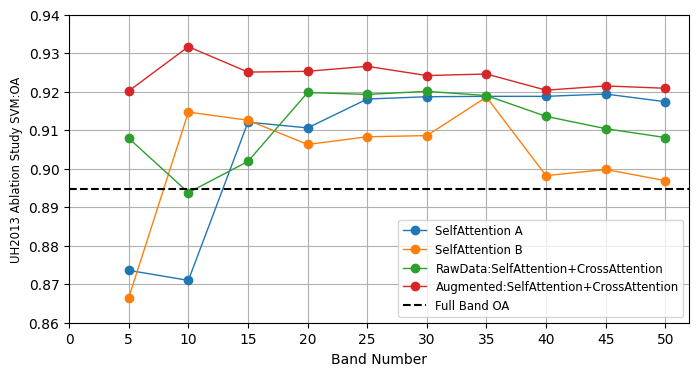

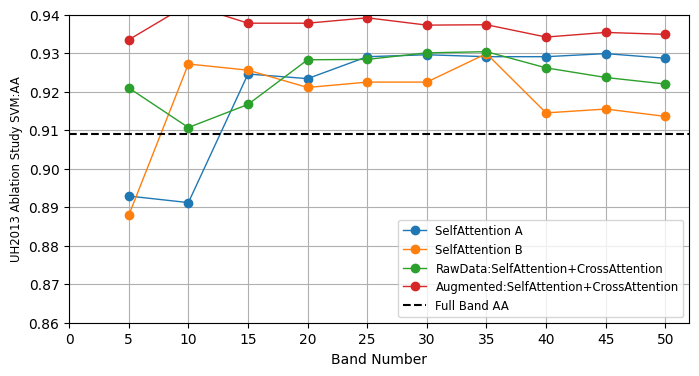

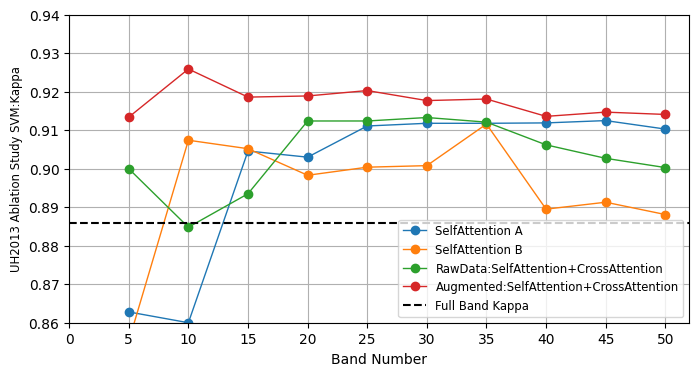

In [ ]:
# SVM Test Output
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


# Trento P9 SVM test data
data = {
     "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
    'SelfAttention A':[ 0.9174, 0.9287, 0.9103, 0.9194, 0.9299, 0.9125, 0.9188, 0.9291, 0.9119, 0.9188, 0.9291, 0.9118, 0.9187, 0.9296, 0.9118, 0.9181, 0.9291, 0.9111, 0.9106, 0.9234, 0.9030, 0.9121, 0.9246, 0.9046, 0.8710, 0.8912, 0.8600, 0.8736, 0.8929, 0.8628],
'SelfAttention B':[0.8969, 0.9136, 0.8881, 0.8998, 0.9155, 0.8913, 0.8982, 0.9145, 0.8895, 0.9186, 0.9299, 0.9116, 0.9086, 0.9225, 0.9008, 0.9083, 0.9225, 0.9004, 0.9063, 0.9211, 0.8983, 0.9126, 0.9256, 0.9052, 0.9147, 0.9272, 0.9074, 0.8665, 0.8879, 0.8552],
'RawData:SelfAttention+CrossAttention':[    0.9081, 0.9220, 0.9003, 0.9104, 0.9237, 0.9027, 0.9136, 0.9262, 0.9062, 0.9190, 0.9304, 0.9121, 0.9201, 0.9301, 0.9133, 0.9193, 0.9284, 0.9124, 0.9198, 0.9283, 0.9124, 0.9019, 0.9167, 0.8935, 0.8938, 0.9107, 0.8848, 0.9079, 0.9210, 0.9000],
'Augmented:SelfAttention+CrossAttention':[0.9209, 0.9349, 0.9141, 0.9215, 0.9354, 0.9147, 0.9204, 0.9342, 0.9136, 0.9246, 0.9374, 0.9181, 0.9242, 0.9373, 0.9177, 0.9266, 0.9392, 0.9203, 0.9253, 0.9378, 0.9189, 0.9251, 0.9378, 0.9186, 0.9317, 0.9427, 0.9259, 0.9202, 0.9335, 0.9134]
}
# Creating a DataFrame
df_uh_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SelfAttention A', 'SelfAttention B','RawData:SelfAttention+CrossAttention', 'Augmented:SelfAttention+CrossAttention']

# Define the band_numbers variable
band_numbers = df_uh_svm['Band Number'].unique()
#Overall accuracy: 0.9883313488688552
#Average accuracy: 0.9824927817801358
#Kappa: 0.9843540637091338
full_bands = {'OA': 0.8948, 'AA': 0.9091, 'Kappa': 0.8859}

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh_svm[df_uh_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 Ablation Study SVM:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.8600, 0.9400)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()